In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import time
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
from tqdm import tqdm_notebook

from ops import BatchNorm
from ops import conv2d
from ops import lrelu
from ops import deconv2d
from ops import linear

from utils import get_image
from utils import save_images
from utils import inverse_transform
from utils import imread

In [3]:
cmd = 'pkill -f .*tensorboard'
subprocess.run(cmd.split(' '))
cmd = 'tensorboard --logdir=logs --port=6060'
process = subprocess.Popen(cmd.split(' '))

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from [here](https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM) (or clone [this](https://github.com/carpedm20/DCGAN-tensorflow) repo and type `python download.py celebA`) and copy the files to `celebA` in the directory of this notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [4]:
DATA_PATH = Path('.').joinpath('celebA') # Path to the dataset with celebA faces
Z_DIM = 100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE = 64*8 # Length of first tensor in generator

IMAGE_SIZE = 64 # Shapes of input image
BATCH_SIZE = 64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

In [5]:
assert(DATA_PATH.is_dir()), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [6]:
def generator(z, is_training):
    """
    Creates the generator which generates images from noise
    
    Parameters
    ----------
    z : array-like, shape (100,)
        The random input to generate images from
    is_training : bool
        Whether we are training or predicting
    
    Returns
    -------
    Tensor, shape (IMAGE_SIZE, IMAGE_SIZE, 3)
        The resulting image from the generator
        
    References
    ----------
    https://arxiv.org/pdf/1511.06434.pdf
    """
    
    # Firstly let's reshape input vector into 3-d tensor.
    # NOTE: linear is defined in ops.py, and is equivalent to a Dense layer
    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    # Reshape the output from the dense layer
    # NOTE: The -1 denotes that the rest of the shape should be infered
    # NOTE: This is a rank 4 tensor
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    # NOTE: ReLU before batch normalization is disputed in general
    # https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/
    h_in_b = BatchNorm(epsilon=1e-3, momentum = 0.99, name='g_h0_b')(h_in, is_training)
    h_in_a = tf.nn.relu(h_in_b, name='g_h0_a')
    
    h1 = deconv2d(h_in_a, 
                  [BATCH_SIZE, 8, 8, 512],
                  k_h=5, 
                  k_w=5, 
                  d_h=2, 
                  d_w=2, 
                  name='g_h1_a_deconv2d')
    h1_b = BatchNorm(epsilon=1e-5, momentum = 0.9, name='g_h1_b')(h1, is_training)
    h1_a = tf.nn.relu(h1_b, name='g_h1_a')
    
    h2 = deconv2d(h1_a, 
                  [BATCH_SIZE, 16, 16, 256],
                  k_h=5, 
                  k_w=5, 
                  d_h=2, 
                  d_w=2,
                  name='g_h2_deconv2d')
    h2_b = BatchNorm(epsilon=1e-5, momentum = 0.9, name='g_h2_b')(h2, is_training)
    h2_a = tf.nn.relu(h2_b, name='g_h2_a')
    
    h3 = deconv2d(h2_a, 
                  [BATCH_SIZE, 32, 32, 128],
                  k_h=5, 
                  k_w=5, 
                  d_h=2, 
                  d_w=2,
                  name='g_h3_deconv2d')
    h3_b = BatchNorm(epsilon=1e-5, momentum = 0.9, name='g_h3_b')(h3, is_training)
    h3_a = tf.nn.relu(h3_b, name='g_h3_a')
    
    # Last layer of G and first of D are not Batch normalised, 
    # so that model can learn correct mean and scale of data distribution
    h_out = deconv2d(h3_a,
                     [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
                     k_h=5, 
                     k_w=5, 
                     d_h=2, 
                     d_w=2,
                     name='g_out')

    return tf.nn.tanh(h_out)

Tensorboard can be accessed at http://localhost:6060

In [7]:
# Visualize the tensorboard
tf.reset_default_graph()

with tf.Session() as sess:
    
    is_training = tf.placeholder(tf.bool, name='is_training')

    with tf.variable_scope("G") as scope:
        z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
        G = generator(z, is_training)

    writer = tf.summary.FileWriter('logs', sess.graph)
    writer.close()

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to flatten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [8]:
def discriminator(image, is_training):
    """
    Creates the generator which generates images from noise
    
    Parameters
    ----------
    image : Tensor, shape (IMAGE_SIZE, IMAGE_SIZE, 3)
        Either a real image, or an image from a generator
    is_training : bool
        Whether we are training or predicting
    
    Returns
    -------
    probabilities : Tensor, shape (2,)
        The probabilities that the the image is real or fake
    linear_out : Tensor, shape (2,)
        The linear_output before applying the sigmoid funtion
        
    References
    ----------
    https://arxiv.org/abs/1609.04468 
    """

    # Last layer of G and first of D are not Batch normalised, 
    # so that model can learn correct mean and scale of data distribution
    h0 = conv2d(image, 64, k_h=5, k_w=5, d_h=2, d_w=2, name='d_h0_conv2d')
    h0_a = lrelu(h0, leak=0.2, name='d_h0_a')
    
    h1 = conv2d(h0_a, 128, k_h=5, k_w=5, d_h=2, d_w=2, name='d_h1_conv2d')
    h1_b = BatchNorm(epsilon=1e-5, momentum = 0.9, name='d_h1_b')(h1, is_training)
    h1_a = lrelu(h1_b, leak=0.2, name='d_h1_a')

    h2 = conv2d(h1_a, 256, k_h=5, k_w=5, d_h=2, d_w=2, name='d_h2_conv2d')
    h2_b = BatchNorm(epsilon=1e-5, momentum = 0.9, name='d_h2_b')(h2, is_training)
    h2_a = lrelu(h2_b, leak=0.2, name='d_h2_a')
    
    h3 = conv2d(h2_a, 512, k_h=5, k_w=5, d_h=2, d_w=2, name='d_h3_conv2d')
    h3_b = BatchNorm(epsilon=1e-5, momentum = 0.9, name='d_h3_b')(h3, is_training)
    h3_a = lrelu(h3_b, leak=0.2, name='d_h3_a')    
    
    h2_f = tf.contrib.layers.flatten(h3_a)
    
    linear_out = linear(h2_f, 1, 'linear_out') 
    
    return tf.nn.sigmoid(linear_out), linear_out

In [9]:
# Visualize the tensorboard
tf.reset_default_graph()

with tf.Session() as sess:  
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    with tf.variable_scope("G") as scope:
        z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
        G = generator(z, is_training)
    
    with tf.variable_scope('D') as scope:
        images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
        D_real, D_real_logits = discriminator(images, is_training)
        
    writer = tf.summary.FileWriter('logs', sess.graph)
    writer.close()

Now let's define generator and discriminator.

In [10]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [11]:
# NOTE: tf.reduce_mean is the average
# NOTE: The following loss has been found to give better stability
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, 
                                                                     labels=tf.ones_like(D_real)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, 
                                                                     labels=tf.zeros_like(D_fake)))
d_loss = d_loss_real + d_loss_fake
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, 
                                                                labels=tf.ones_like(D_fake)))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [12]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

Load data:

In [13]:
data = sorted(DATA_PATH.glob('*.jpg'))
assert(len(data) > 0), 'Length of training data should be more than zero'

Functions for training and evaluations.

In [14]:
def load(sess, load_dir):
    """
    Loads the network's paramaters
    
    Parameters
    ----------
    sess : Session
        The session to load for
    load_dir : Path or str
        Path to the load directory
    """
    
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(str(load_dir))
    
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [15]:
sample = inverse_transform(get_image(data[np.random.randint(len(data))], IMAGE_SIZE, IMAGE_SIZE))
fig, ax = plt.subplots()
# NOTE: [..., ::-1] converts from BGR to RGB
ax.imshow(sample[...,::-1])
plt.show()

<IPython.core.display.Javascript object>

In [16]:
def get_epoch_and_batch(sample_dir):
    """
    Obtains the current epoch and batch from the sample directory
    
    Notes
    -----
    save_frequency must be equal to sample_frequency in `train` for this to work
    
    Parameters
    ----------
    save_dir: Path or str
        Path where to save parameters

    Returns
    -------
    cur_epoch : int
        Integer of the epoch last saved
    cur_batch : int
        Integer of the last batch saved
    """
    
    images = sorted(sample_dir.glob('*.png'))
    if len(images) == 0:
        return 0, 0
    else:
        last_save = images[-1]
        _, cur_epoch, cur_batch = last_save.name.split('.png')[0].split('_')
        return int(cur_epoch), int(cur_batch)

In [17]:
def train(sess,
          load_dir=None, 
          save_frequency=100, 
          sample_frequency=100, 
          sample_dir='sample_faces',
          save_dir='checkpoint', 
          max_to_keep=3, 
          model_name='dcgan.model',
          n_epochs=25,
          n_generator_update=2):
    """
    Trains the GAN
    
    Parameters
    ----------
    sess : Session
        The session to train for
    load_dir : None or Path or str
        Path to directory with the parameters
    save_frequency: int
        How often save parameters
    sample_frequency: int
        How often sample faces
    sample_dir: Path or str
        Directory for generated images
    save_dir: Path or str
        Path where to save parameters
    max_to_keep: int
        How many last checkpoints to store
    model_name: str
        Name of model
    n_epochs: int
        Number epochs to train
    n_generator_update: int
        How many times run generator updates per one discriminator update
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None and load_dir.joinpath('checkpoint').is_file():
        print('Reading checkpoints...')
        try:
            load(sess, str(load_dir))
            add_to_epoch, add_to_batch = get_epoch_and_batch(sample_dir)
            print('Loaded checkpoints')
        except:
            print('WARNING! Reading checkpoints failed')
            add_to_epoch = 0
            add_to_batch = 0
            try:
                tf.global_variables_initializer().run()
            except:
                tf.initialize_all_variables().run()
    else:
        add_to_epoch = 0
        add_to_batch = 0
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in tqdm_notebook(range(n_epochs), desc='Epoch'):
        if epoch < add_to_epoch:
            continue
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        # Store last epoch in own directory
        new_dir = Path('.').joinpath(f'epoch_{epoch-1}_{time.strftime("%Y-%m-%d_%H-%M-%S")}')
        new_dir.mkdir()
        old_files = Path(save_dir).glob('*')
        for f in old_files:
            shutil.copy(f, new_dir.joinpath(f.name))
            print(f'Copied {f} to {new_dir.joinpath(f.name)}')
        for idx in tqdm_notebook(range(0, batch_idxs), desc='Batch', leave=False):
            if idx <= add_to_batch:
                continue
            # Reset add to batch
            add_to_batch = -1
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z, is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim, feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1

            print('Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}'.format(
                  epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print('Saved model')
                saver.save(sess, str(save_dir.joinpath(model_name)))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples,
                            [MERGE_X, BATCH_SIZE//MERGE_X],
                            str(sample_dir.joinpath('train_{:02d}_{:04d}.png'.format(epoch, idx))))
                print('Sample')

In [18]:
save_dir = Path('.').absolute().joinpath('checkpoint')
sample_dir = Path('.').absolute().joinpath('sample_faces')
save_dir.mkdir(exist_ok=True)
sample_dir.mkdir(exist_ok=True)

with tf.Session() as sess:
    train(sess, load_dir=save_dir, save_dir=save_dir, sample_dir=sample_dir)

Reading checkpoints...
INFO:tensorflow:Restoring parameters from /home/loeiten/assignment/checkpoint/dcgan.model
Loaded checkpoints
Epoch: [24] [3164/3165] time: 44268.6543, d_loss: 1.05090261, g_loss: 2.29118919



If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [19]:
def display(path):
    """
    Displays the image located at the path
    
    Parameters
    ----------
    path : Path or str
        Path to image
    """
    
    images = imread(path)
    fig, ax = plt.subplots(figsize=(7,7))
    # NOTE: [..., ::-1] converts from BGR to RGB
    ax.imshow(images[..., ::-1])
    plt.show()

In [20]:
faces_dir = Path('.').absolute().joinpath('sample_faces')

INFO:tensorflow:Restoring parameters from /home/loeiten/assignment/checkpoint/dcgan.model


<IPython.core.display.Javascript object>


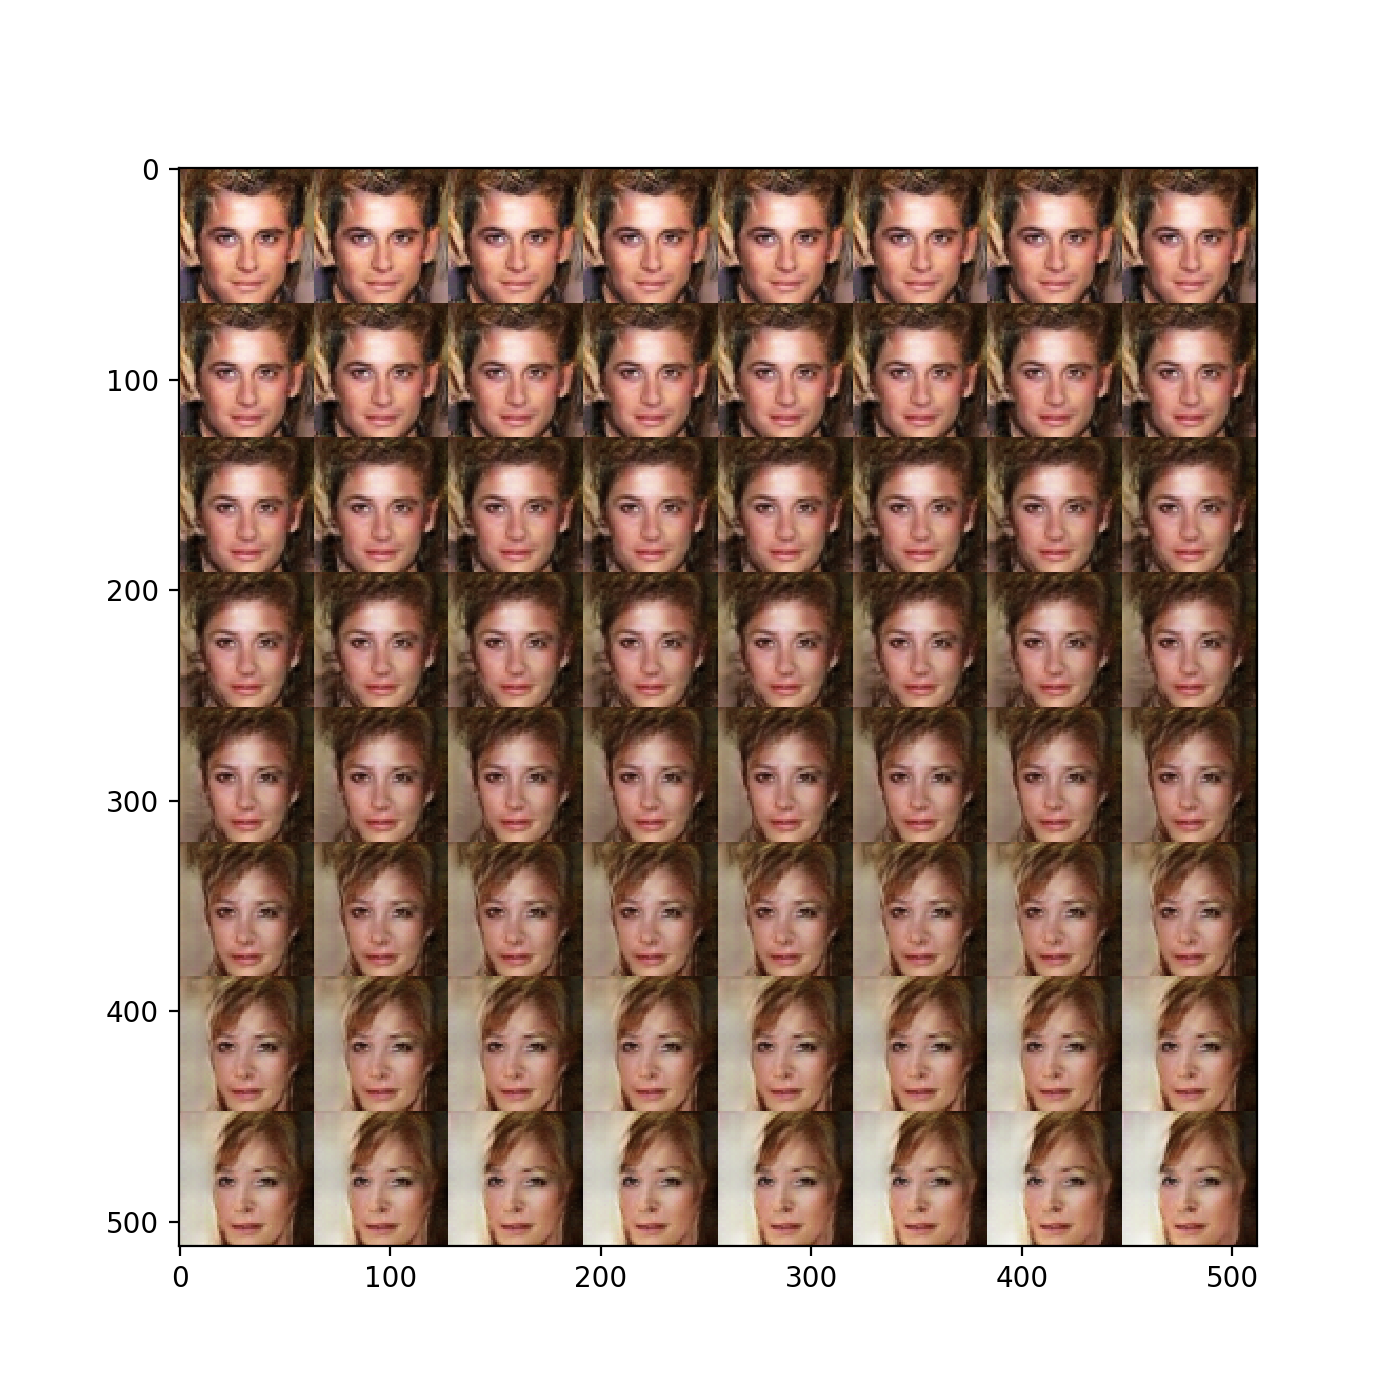

In [21]:
face_interpolation_image = faces_dir.joinpath('face_interpolation.png')
face_interpolation_data = faces_dir.joinpath('face_interpolation.npy')

if not face_interpolation_image.is_file():
    # Reseed
    np.random.seed(20)
    z_1 = np.random.uniform(-1, 1, Z_DIM).astype(np.float32)
    z_2 = np.random.uniform(-1, 1, Z_DIM).astype(np.float32)
    # NOTE: As Batch size is 64, we will vary alpha from 0 to 1 in 64 steps
    batchz = [alpha*z_1 + (1-alpha)*z_2 for alpha in np.linspace(0, 1, 64)]
    
    # Feed batchz to obtain images
    with tf.Session() as sess:
        load(sess, './checkpoint')
        generated_image = sess.run(G, feed_dict={z: batchz, is_training: False})
    np.save(face_interpolation_data, generated_image)

generated_image = np.load(face_interpolation_data)        
# Utils are made so that it's easiest to use save_images to save the image and restore it again
save_images(generated_image, [MERGE_X, BATCH_SIZE//MERGE_X], face_interpolation_image)   
display(face_interpolation_image)

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

INFO:tensorflow:Restoring parameters from /home/loeiten/assignment/checkpoint/dcgan.model


<IPython.core.display.Javascript object>


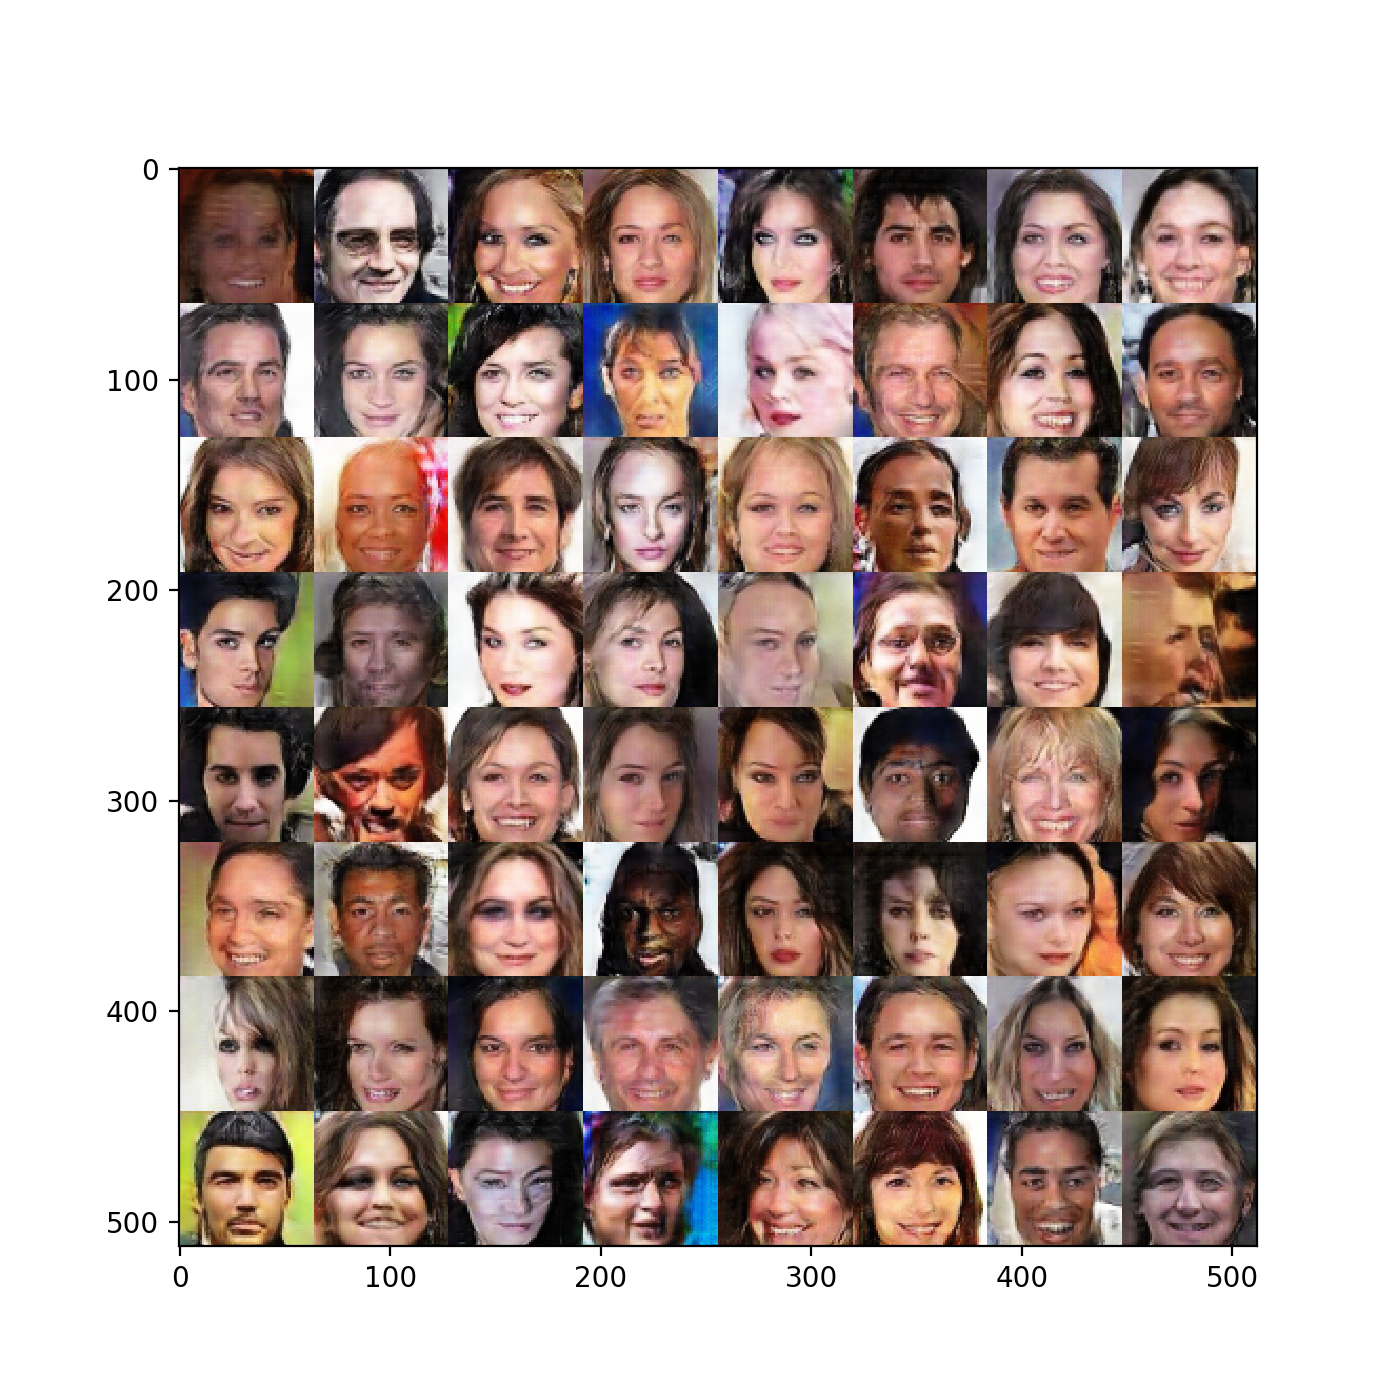

In [22]:
random_faces_image = faces_dir.joinpath('random_faces.png')
random_faces_data = faces_dir.joinpath('random_faces.npy')

if not random_faces_data.is_file():
    # Reseed
    np.random.seed(0)
    random_batch = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    with tf.Session() as sess:
        load(sess, './checkpoint')
        random_images = sess.run(G, feed_dict={z: random_batch, is_training: False})
    np.save(random_faces_data, random_images)

random_images = np.load(random_faces_data)
save_images(random_images, [MERGE_X, BATCH_SIZE//MERGE_X], random_faces_image)
display(random_faces_image)

We now find the indexes of similing and non-smiling faces manually. Counting starts from top left corner and runs towards right

INFO:tensorflow:Restoring parameters from /home/loeiten/assignment/checkpoint/dcgan.model


<IPython.core.display.Javascript object>


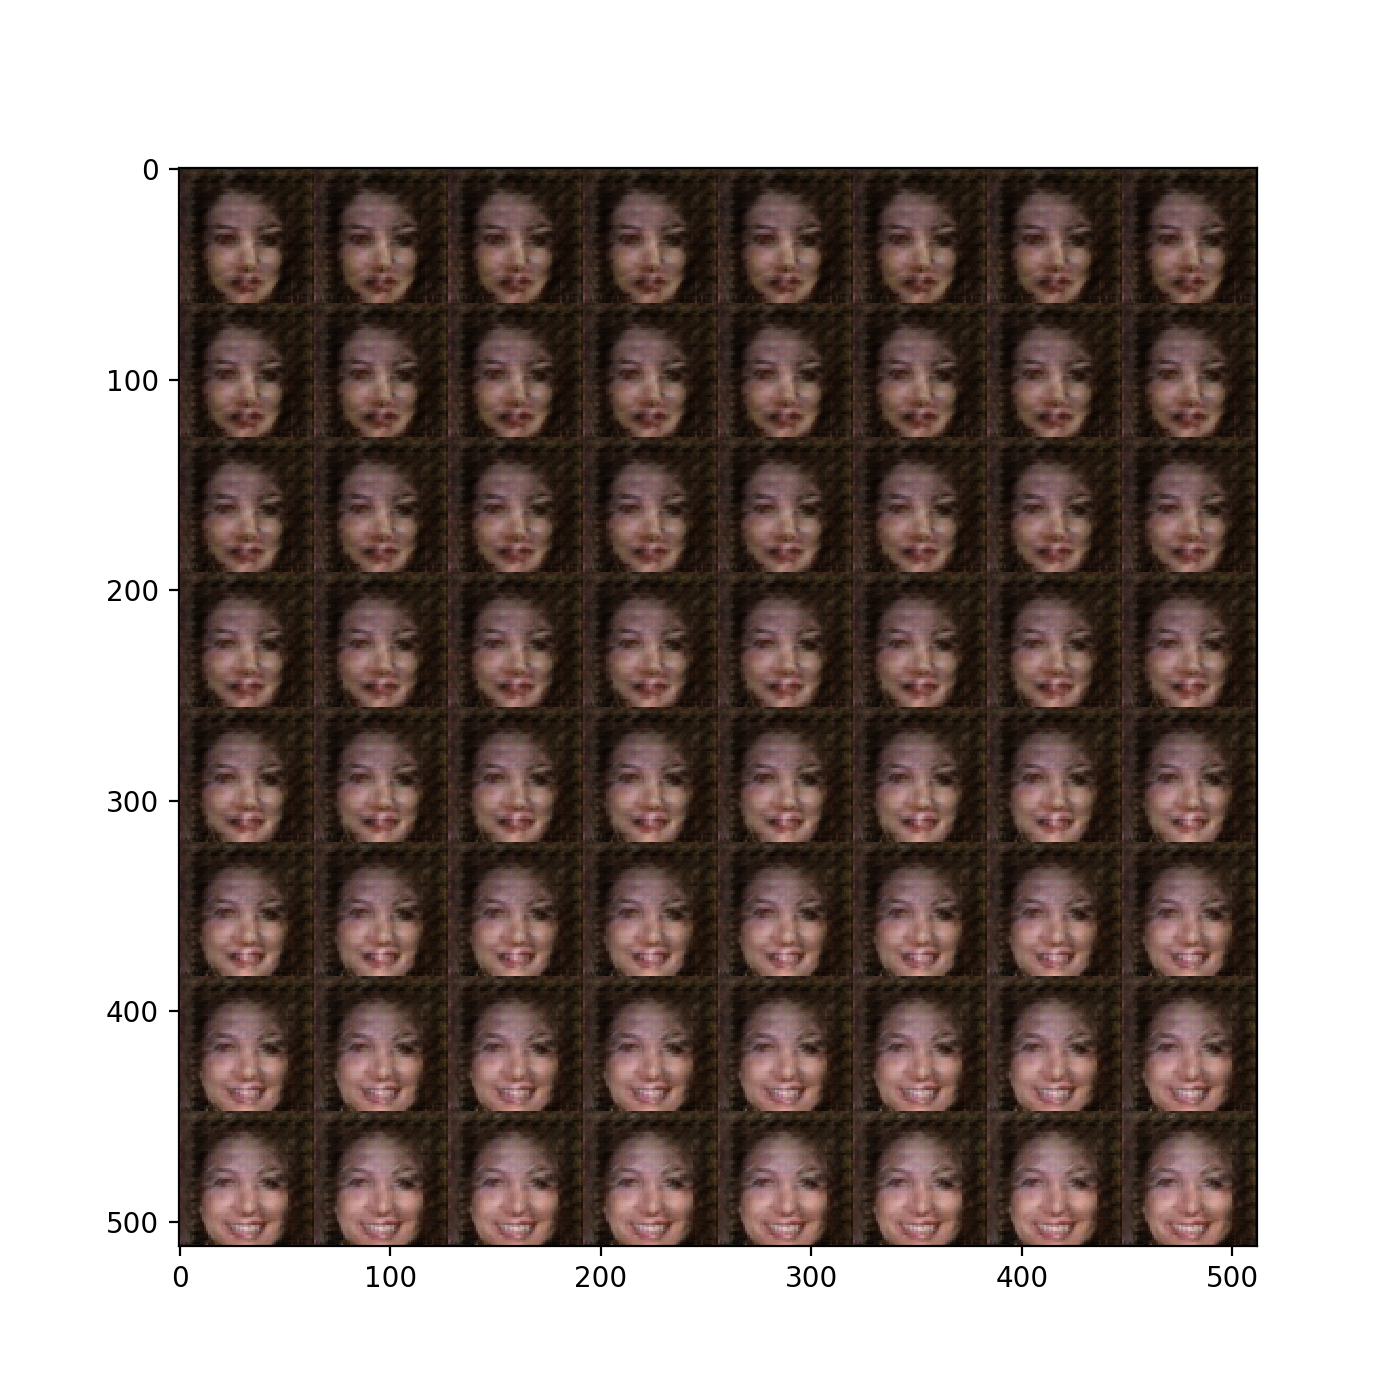

In [23]:
smile_image = faces_dir.joinpath('smile.png')
smile_data = faces_dir.joinpath('smile.npy')

if not smile_data.is_file():
    smiling_indices = [0, 1, 6, 7, 
                       8, 10, 13, 14,
                       17, 18, 20,
                       30,
                       33, 34, 38,
                       40, 47,
                       49, 51, 52, 53, 54,
                       60, 61, 62, 63
                      ]
    non_smiling_indices = [3, 4, 5,
                           11, 12,
                           19, 21,
                           24, 26, 27, 28,
                           32, 35, 39,
                           44, 45, 46,
                           55,
                           56, 59
                          ]
    
    avg_smile = np.mean(random_batch[smiling_indices, :], axis=0)
    avg_non_smile = np.mean(random_batch[non_smiling_indices, :], axis=0)
    
    # We use the same interpolation strategy as before
    smile_batch = [alpha*avg_smile + (1-alpha)*avg_non_smile for alpha in np.linspace(0, 1, 64)]
    
    with tf.Session() as sess:
        load(sess, './checkpoint')
        smile_images = sess.run(G, feed_dict={z: smile_batch, is_training: False})
    np.save(smile_data, smile_images)

smile_images = np.load(smile_data)
save_images(smile_images, [MERGE_X, BATCH_SIZE//MERGE_X], smile_image)
display(smile_image)

If faces looks really cool, add bonus 1 point to your score.